In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [286]:
df = pd.read_csv('../data/raw/training_v2.csv')

pos_df = df[df.hospital_death == 1]
neg_df = df[df.hospital_death == 0].sample(frac=0.09)

df = pd.concat([pos_df, neg_df])
df = df.sample(frac=1).reset_index(drop=True)

numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

In [300]:
high_corr = correlation_matrix.hospital_death[correlation_matrix.hospital_death.abs() > 0.05]
feature_columns = high_corr.index.values

In [210]:
important_features_corr = df[feature_columns].corr()

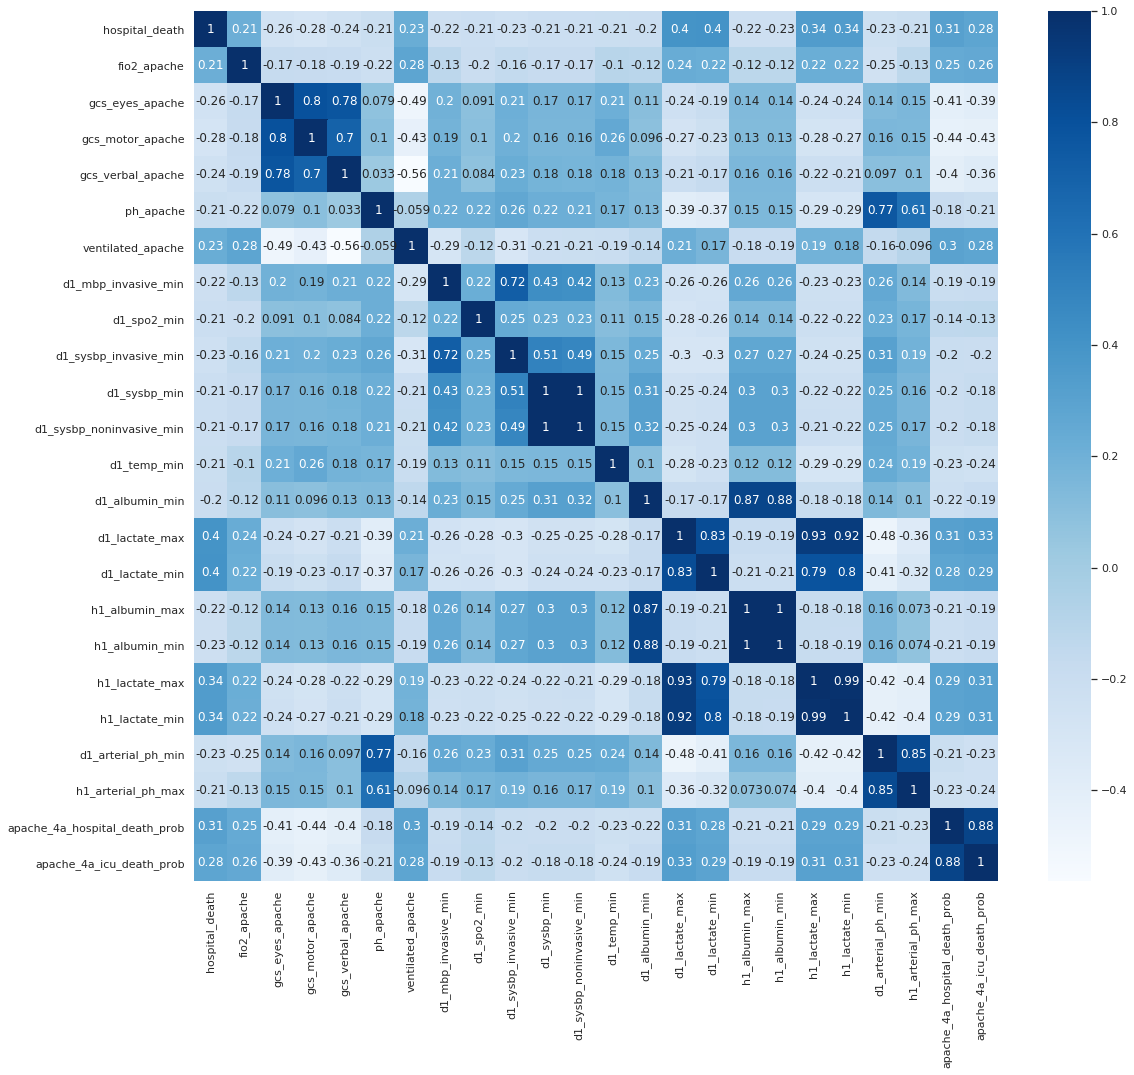

In [37]:
plt.figure(figsize=(18, 16))
sns.heatmap(important_features_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

In [301]:
data_df = df[feature_columns]

In [302]:
mask = np.random.random(data_df.shape[0]) < 0.8
train_df = data_df[mask]
test_df = data_df[~mask]

In [303]:
train_labels = train_df.hospital_death
train_samples = train_df.drop(columns='hospital_death')

test_labels = test_df.hospital_death
test_samples = test_df.drop(columns='hospital_death')

In [306]:
import xgboost as xgb

scale_pos_weight = 1 # (train_labels == 0).sum() / (train_labels == 1).sum())

model = xgb.XGBClassifier(n_estimators=128,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          subsample=1,
                          random_state=42,
                          scale_pos_weight=scale_pos_weight,
                          n_jobs=-1)

model.fit(train_samples, train_labels, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=None, n_estimators=128, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [307]:
from sklearn.metrics import classification_report, roc_auc_score

y_true = test_labels.values
y_pred = model.predict_proba(test_samples)

print(classification_report(y_true, np.argmax(y_pred, axis=1)))

auc_score = roc_auc_score(y_true, y_pred[:, 1])
print('\nAUROC: {}'.format(auc_score))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1405
           1       0.84      0.82      0.83      1609

    accuracy                           0.82      3014
   macro avg       0.82      0.82      0.82      3014
weighted avg       0.82      0.82      0.82      3014


AUROC: 0.9040428727199539
